In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
os.makedirs("../out", exist_ok=True)

# Q4: Extra Credit

Use this notebook for question 4. 

In [7]:
# We recommend using this function, but you can explore other methods as well (e.g., ndimage.shift).
from scipy.interpolate import RectBivariateSpline

# The function below could be useful as well :) 
from numpy.linalg import lstsq

def LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2)):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[np.array(4, 1)] rect : Coordinates of template which has the form [x1, y1, x2, y2], where
                                  [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[float] dp_thresh     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization
    :param[np.array(2, 1)] p0   : Initial movement vector [dp_x0, dp_y0]

    :return[np.array(2, 1)] p   : Final movement vector [dp_x, dp_y]
    """
	
    # Initialize p to p0. Don't remove these lines.
    p = p0
    delta_p = np.ones((1,2))

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your LK implementation here: 

    # infor: w and h
    w = int(np.round(rect[2] - rect[0] + 1))
    h = int(np.round(rect[3] - rect[1] + 1))
    # Use whole img to build mode:
    h_all=np.arange(0,It.shape[0])
    w_all=np.arange(0,It.shape[1])

    # build mode for interpolation of It, It1
    mode = RectBivariateSpline(h_all, w_all, It)
    mode1 = RectBivariateSpline(h_all, w_all, It1)

    # index for stop loop
    times = 0
    # values in template, rectangle is inclusive
    temp_x=np.arange(rect[0],rect[2]+1)[:w]
    temp_y=np.arange(rect[1],rect[3]+1)[:h]

    # get interpolation value of template from mode
    template = mode(temp_y,temp_x)

    # compare with threshold
    delta_threshold=delta_p[0][0]**2 + delta_p[0][1]**2

    # incase input get changed, make a copy
    rect1= np.copy(rect).astype(float)

    while ( delta_threshold>= threshold) and (times<num_iters):
        # 1. Warp the template;
        # update rect
        rect1[0] = p[0] + rect[0]
        rect1[1] = p[1] + rect[1]
        rect1[2] = p[0] + rect[2]
        rect1[3] = p[1] + rect[3]

        # 2. Build your linear system (Q1.1.2);
        # get img of X' using interpolation
        x1=np.arange(rect1[0],rect1[2]+1)[:w]
        y1=np.arange(rect1[1],rect1[3]+1)[:h]

        # get new image values with interpolation
        new_img = mode1(y1,x1)

        # get b: n*1
        b_temp = template.reshape(-1,1)
        b_new_img=new_img.reshape(-1,1)
        b=b_temp-b_new_img
        # get A: n*2
        A=np.zeros((w*h,2))

        # gradient in x and y direction, derivative=1
        gradient_x=mode1(y1, x1, dy=1)
        gradient_x=gradient_x.reshape(1,-1)
        gradient_y=mode1(y1, x1, dx=1) 
        gradient_y=gradient_y.reshape(1,-1)
        # append to A
        A[:,0]=gradient_x[0]
        A[:,1]=gradient_y[0]

        # 3. Run least-squares optimization (eq. (1.4));
        delta_p=np.linalg.lstsq(A, b, rcond=None)[0]

        # 4. Update the local motion.
        p[0]+=delta_p[0]
        p[1]+=delta_p[1]
        #print(p,delta_p)

        delta_threshold=delta_p[0]**2 + delta_p[1]**2
        times+=1

    
    # ----------------------------------------------------------------------------------------------
    return p,delta_threshold

In [8]:
# get first frame
import cv2
cap = cv2.VideoCapture('video1.mp4')
first = True
while cap.isOpened():
    ret,frame = cap.read()
    frame = cv2.resize(frame,(640,480))
    #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imwrite("video1_0.jpg", frame)
    #count = count + 1
    if (cv2.waitKey(10) & 0xFF == ord('q')) or (first==True):
        break
cap.release()
cv2.destroyAllWindows() 

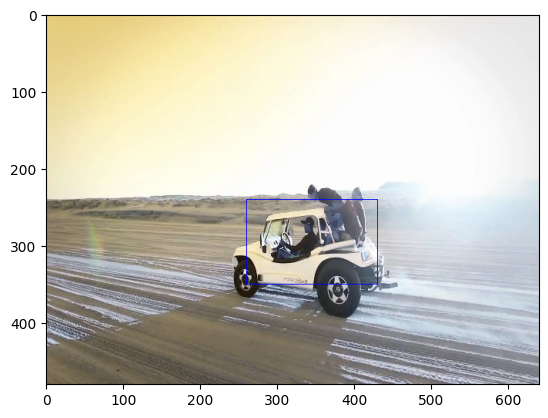

In [9]:
# get first rect
#rect = [240.0, 230.0, 450.0, 400.0]
rect = [260.0, 240.0, 430.0, 350.0]
first = cv2.imread("video1_0.jpg")
first = cv2.rectangle(first, (int(rect[0]),int(rect[1])), (int(rect[2]),int(rect[3])), (0, 0, 255), 1)
plt.figure()
plt.imshow(first)

In [10]:
import cv2
import time

def video_process(rect_0,name,num,drift_threshold = 5):
    cap = cv2.VideoCapture(name)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    count = 0
    start = time.time()
    #rect_0 =[260.0, 240.0, 430.0, 350.0]
    pn=np.zeros(2)
    # initial rect
    rect_it=np.copy(rect_0)
    rect_it0=np.copy(rect_0)

    num_iters = 1e4
    threshold = 1e-2

    rect_it=np.copy(rect_0)
    rect_it0=np.copy(rect_0)
    first_frame = cv2.imread("video"+str(num)+"_0.jpg")
    first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    It0 = first_frame.copy()
    It = first_frame.copy()
    seconds=[0,2,4,6,8,10]
    index=0
    i=0

    while cap.isOpened():
        ret,frame = cap.read()
        frame = cv2.resize(frame,(640,480))
        show_frame = frame.copy()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame=np.array(frame)
        #print(frame)

        #print(frame.shape)
        pn,delta_p = LucasKanade(It, frame, rect_it, threshold, num_iters, p0=np.copy(pn))
        # append result to results list
        rect_new=np.copy(rect_it)
        rect_new[0] += pn[0]
        rect_new[1] += pn[1]
        rect_new[2] += pn[0]
        rect_new[3] += pn[1]
        # second formula, start with pn, use T1
        pn_star,delta_p_star=LucasKanade(It0, frame, rect_it0, threshold, num_iters, p0=np.copy(pn))
        # update with p_star
        p_diff = pn_star-pn
        if np.linalg.norm(p_diff) <= drift_threshold and delta_p < threshold:
            rect_it=np.copy(rect_it0)
            rect_it[0] += pn_star[0]
            rect_it[1] += pn_star[1]
            rect_it[2] += pn_star[0]
            rect_it[3] += pn_star[1]
            It=frame
        


        show_frame = cv2.rectangle(show_frame, (int(rect_new[0]),int(rect_new[1])), (int(rect_new[2]),int(rect_new[3])), (0, 0, 255), 1)

        if i==fps*seconds[index]:
            cv2.imwrite("video"+str(num)+"_"+str(seconds[index])+".jpg", show_frame) 
            index+=1
        
        cv2.imshow('LK tracking', show_frame)
        #cv2.imwrite("frame%d.jpg" % count, frame)
        i+=1
        if (cv2.waitKey(10) & 0xFF == ord('q')) or (i>(fps*10)):
            break

    cap.release()
    cv2.destroyAllWindows() 

In [11]:
video_process([260.0, 240.0, 430.0, 350.0],'video1.mp4',1)

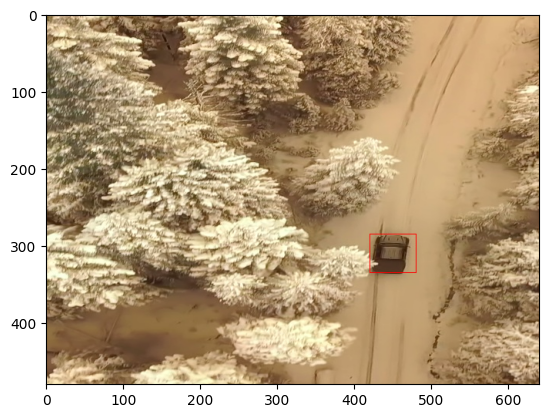

In [12]:
import cv2
cap = cv2.VideoCapture('video2.mp4')
first = True
while cap.isOpened():
    ret,frame = cap.read()
    frame = cv2.resize(frame,(640,480))
    #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imwrite("video2_0.jpg", frame)
    #count = count + 1
    if (cv2.waitKey(10) & 0xFF == ord('q')) or (first==True):
        break
cap.release()
cv2.destroyAllWindows() 
# get first rect
#rect = [240.0, 230.0, 450.0, 400.0]
rect = [420.0, 285.0, 480.0, 335.0]
first = cv2.imread("video2_0.jpg")
first = cv2.rectangle(first, (int(rect[0]),int(rect[1])), (int(rect[2]),int(rect[3])), (255, 0, 0), 1)
plt.figure()
plt.imshow(first)

In [13]:
video_process([420.0, 285.0, 480.0, 335.0],'video2.mp4',2,2)